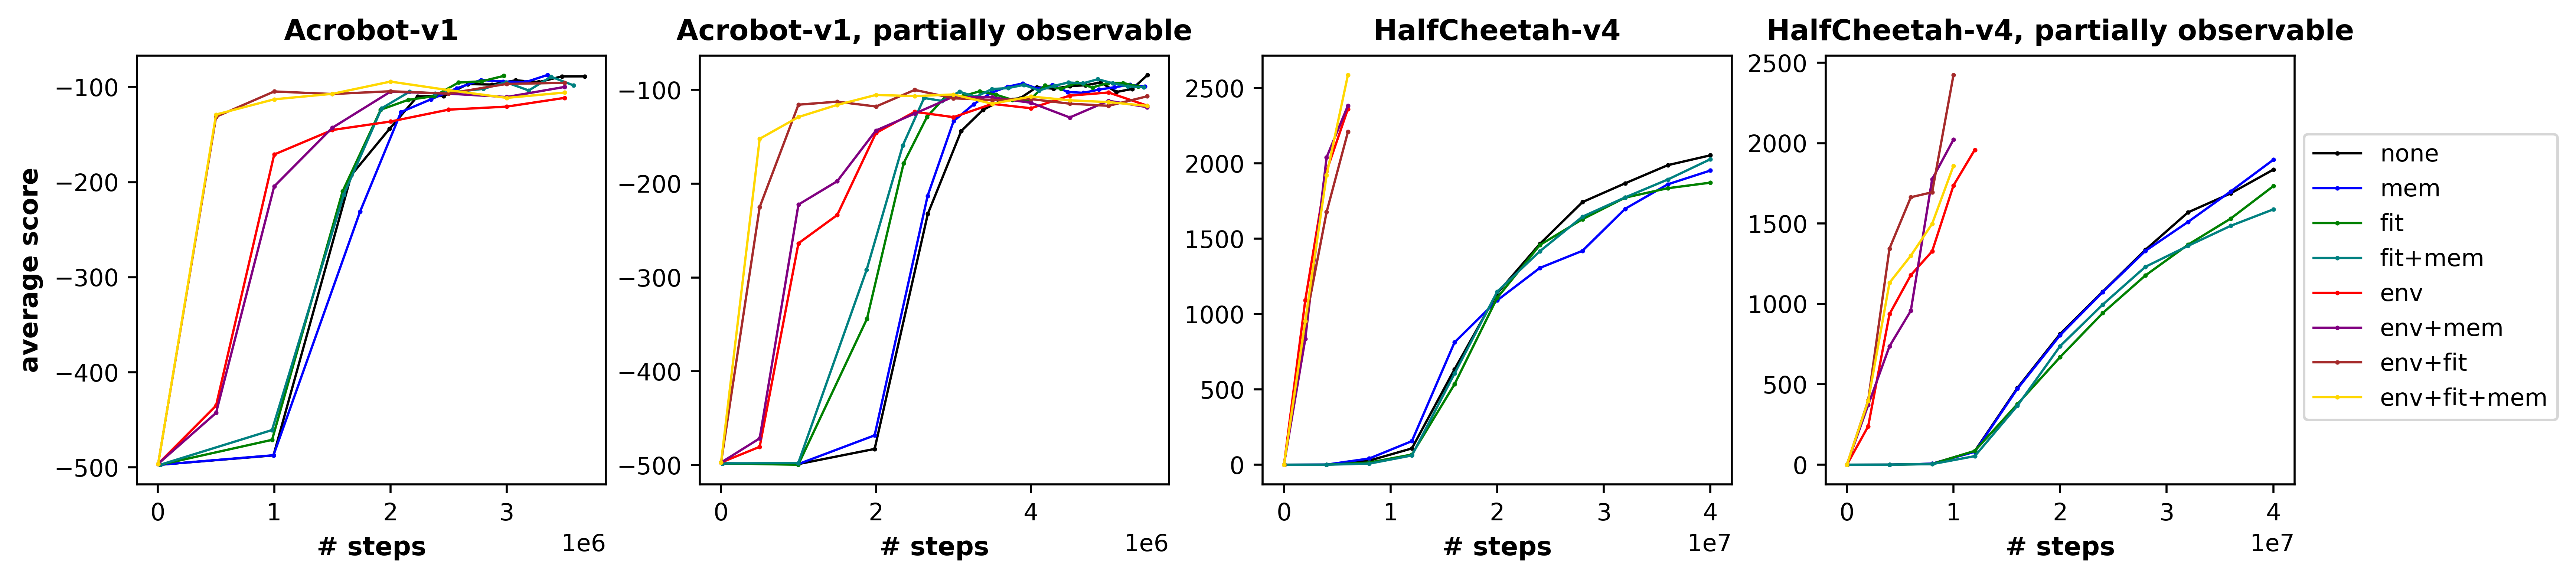

In [1]:
import os
import pickle
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
font = {"family": "sans-serif", "weight": "normal", "size": 9.2}
mpl.rc("font", **font)
plt.rc("figure", figsize=[15, 3])
plt.rc("figure", titlesize=20)
plt.rc("axes", labelsize=15)
plt.rc("axes", titlesize=15)
MAX_INT = 2**31 - 1
fig, axs = plt.subplots(1, 4, dpi=500)
max_score = 0
max_score_total_num_env_steps = 0
evaluations = np.empty((4, 8, 2000, 2))
evaluations[:] = np.nan
args = []
path_0 = Path(f"{os.environ['CNEUROMAX_PATH']}/data/gen_transfer")
label = ""
colors = {
    "none": "black",
    "env": "red",
    "fit": "green",
    "mem": "blue",
    "env+fit": "brown",
    "env+mem": "purple",
    "fit+mem": "teal",
    "env+fit+mem": "gold",
}
for i, env in enumerate(["Acrobot-v1", "HalfCheetah-v4"]):
    path_1 = "acrobot_" if env == "Acrobot-v1" else "half_cheetah_"
    for j, partial_obs in enumerate([False, True]):
        path_3 = f"agent.config.partial_obs.{partial_obs}~"
        k = i * 2 + j
        for env_transfer in [False, True]:
            path_2 = "env_transfer/" if env_transfer else "no_env_transfer/"
            num_gens = 5000 if env_transfer else 1000
            for fit_transfer in [False, True]:
                path_4 = f"config.fit_transfer.{fit_transfer}~"
                for mem_transfer in [False, True]:
                    path_5 = f"config.mem_transfer.{mem_transfer}/"
                    label = ""
                    if env_transfer:
                        label += "env+"
                    if fit_transfer:
                        label += "fit+"
                    if mem_transfer:
                        label += "mem"
                    if label == "":
                        label = "none"
                    if label[-1] == "+":
                        label = label[:-1]
                    l = (  # noqa: E741
                        int(env_transfer) * 4
                        + int(fit_transfer) * 2
                        + int(mem_transfer)
                    )
                    step = num_gens // 20
                    if env == "HalfCheetah-v4":
                        step = num_gens // 10
                    for m, gen in enumerate(
                        [
                            1,
                            *list(
                                range(
                                    step,
                                    num_gens + 1,
                                    step,
                                ),
                            ),
                        ],
                    ):
                        path = (
                            path_0
                            / f"{path_1}{path_2}{path_3}{path_4}{path_5}"
                            / f"{gen}/evaluation.pkl"
                        )
                        if not path.exists():
                            continue
                        with path.open("rb") as f:
                            data = pickle.load(file=f)
                        scores: np.ndarray = data[0]
                        total_num_env_steps: int = data[1]
                        if (env_transfer or fit_transfer or mem_transfer) and (
                            total_num_env_steps > max_score_total_num_env_steps
                        ):
                            break
                        mean_score = scores.mean()
                        evaluations[k, l, m] = [
                            mean_score,
                            total_num_env_steps,
                        ]
                        if (
                            env_transfer or fit_transfer or mem_transfer
                        ) and mean_score >= max_score:
                            break
                    if not (env_transfer or fit_transfer or mem_transfer):
                        max_score = np.nanmax(evaluations[k, l, :, 0], axis=0)
                        max_score_index = np.where(
                            evaluations[k, l, :, 0] >= max_score,
                        )[0][0]
                        max_score_total_num_env_steps = evaluations[
                            k,
                            l,
                            max_score_index,
                            1,
                        ]
                        evaluations[
                            k,
                            l,
                            max_score_index + 1 :,
                        ] = np.nan
                    axs[k].plot(
                        evaluations[k, l, :, 1],
                        evaluations[k, l, :, 0],
                        ".-",
                        label=label,
                        c=colors[label],
                        linewidth=0.9,
                        ms=1.5,
                    )
                    title = env
                    if partial_obs:
                        title += ", partially observable"
                    axs[k].set_title(
                        title,
                        {"fontsize": 11, "fontweight": "bold"},
                    )
                    axs[k].set_xlabel(
                        "# steps",
                        {"fontsize": 10, "fontweight": "bold"},
                    )
axs[0].set_ylabel("average score", {"fontsize": 10, "fontweight": "bold"})
axs[0].legend(loc=[4.62, 0.15])
plt.show()